h= 1.0 

[0.1018711+0.j]
[0.1018711]


h= 0.5 

[0.02716397+0.j]
[0.02716397]


h= 0.25 

[0.00690547+0.j]
[0.00690547]


h= 0.125 

[0.00173367+0.j]
[0.00173367]


h= 0.0625 

[0.00043387+0.j]
[0.00043387]




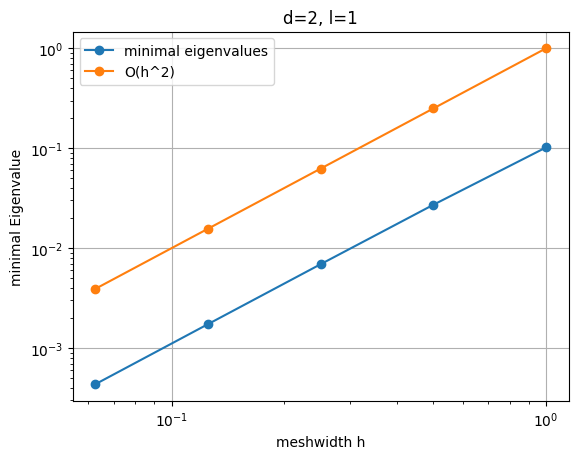

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

meshwidths = np.array([1.0,0.5,0.25,0.125,0.0625]) 
minEV = np.zeros(len(meshwidths))

k = 0

netgen_mesh =unit_square.GenerateMesh(maxh=1)
mesh=Mesh(netgen_mesh)

for h in meshwidths:
    print("h=",h, "\n")
    #Draw(mesh)

    #set function space, for l=0 its normal lagrangian finite elements
    #need to compress to remove DOFs of unrefined mesh after refinement
    H_h = Compress(HDiv(mesh, order = 0, RT=True)) # main function space
    H_H = Compress(HDiv(mesh, order = 1, RT=True)) # high order Function space for Riesz representative  
    
    #low order
    u_h = H_h.TrialFunction() # define the trial function
    v_h = H_h.TestFunction() # define the test function
    #High order
    u_H = H_H.TrialFunction() # define the trial function
    v_H= H_H.TestFunction() # define the test function

    m = BilinearForm(H_h) #define m with the L2 inner product on the low order space
    m += u_h*v_h * dx 
    m.Assemble()

    a = BilinearForm(H_H) # define the Hdiv inner product on the high order space
    a += div(u_H) * div(v_H) * dx
    a += u_H*v_H * dx 
    a.Assemble()

    #mass matrix with mixed basis functions
    a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
    a_mixed += u_h*v_H*dx
    a_mixed.Assemble()

    #compute inverses 
    a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

    m_inv = m.mat.Inverse(freedofs=H_h.FreeDofs())

    #create Matrices for GEV problem

    #c is the low order galerkin matrix
    c = BilinearForm(H_h)
    c += div(u_h) * div(v_h) * dx
    c += u_h*v_h * dx 
    c.Assemble()

    #faster, but might give problems
    # m==m.t
    b = c.mat.T @m_inv.T @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat
    B = b.ToDense().NumPy()

    C = c.mat.ToDense().NumPy()
    
    #For dense calc in Numpy
    # M = m.mat.ToDense().NumPy()
    # A_inv = a_inv.ToDense().NumPy()
    # T = t.ToDense().NumPy()

    # #M == M.T 
    # B = T.T @ M.T @ A_inv @ M @ T

    EV = sp.sparse.linalg.eigs(C, k=1, M=B, which='SM', return_eigenvectors=False)
    print(EV)
    lam_abs = np.abs(EV)
    print(lam_abs)
    minEV[k] = lam_abs[0]

    #iteration update
    k = k + 1
    #uniformly refines mesh, halving meshwidth
    mesh.Refine()
    print("\n")

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,minEV, 'o-', label="minimal eigenvalues")
#plt.loglog(meshwidths,meshwidths,'o-', label="O(h)")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
#plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
#plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
plt.title('d=2, l=1')
plt.legend()
plt.show()
